# SPHINCS+ algorithm

SPHINCS+ is a hash-based signature scheme which consists of a few time signature construction, namely Forest of Random Subsets (FORS) and a hypertree (a tree of trees). 

**FTS schemes** are a signature schemes that allow a key
pair to produce a small number of signatures.

The basic idea is to authenticate a huge number of few-time signature (FTS)
key pairs using a so-called hypertree.

A **hypertree** is a tree of hash-based many-time signatures (MTS)

In [1]:
from math import ceil, floor, log2
from copy import deepcopy
from hashlib import sha256
import hmac
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding
from random import randbytes
from bitarray import bitarray
from enum import Enum

In [2]:
sha256(b'').hexdigest()

'e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855'

## Useful functions

In [3]:
def rot_left(n, d):
    return (n << d)|(n >> (32 - d)) & 0xFFFFFFFF

def rot_right(n, d):
    return (n >> d) | (n << (32 - d)) & 0xFFFFFFFF

In [4]:
rot_right(1, 3)

536870912

#### Base-w

Funkcja konwertująca ciąg bajtów na tablicę poszczególnych bajtów w danym systemie liczbowym _w_. Parametr _out_len_ ogranicza długość tablicy wynikowej.

In [5]:
def xor(a, b):
    return bytes(a[i] ^ b[i] for i in range(len(a)))

def num_to_bytes(num, length=8):
    return int.to_bytes(num, length=length, byteorder='big')

In [6]:
def bits_to_int(x):
    bit_string = x.to01()
    number = int(bit_string, 2)
    return number

def int_to_bits(x):
    bit_array = bitarray()
    bit_array.frombytes(num_to_bytes(x))
    return bit_array

In [7]:
def base_w(X, w, out_len):
    bit_array = bitarray()
    bit_array.frombytes(X)
    m = []
    for i in range(out_len):
        mpart = bit_array[:int(log2(w))]
        bit_array = bit_array[int(log2(w)):]
        number = bits_to_int(mpart)
        m.append(number)
    return m

base_w(b'\x12\x34', 16, 4)

[1, 2, 3, 4]

In [8]:
def adrs_to_bytes(adrs):
    res = b''
    for byte in adrs:
        res += byte
    return res

## Hash Functions

### Generating the masks

We generate the bitmasks for arbitrary length messages using the MFG1 function.

In [9]:
def MGF1(m, size, h=sha256):
    hlen = 32
    output = b''
    for i in range(0, ceil(size/hlen)):
        ibytes = i.to_bytes(4, 'big')
        tmp = h(m + ibytes).digest()
        output = output + tmp
    return output[: size + 1]

In [10]:
mgf_res = MGF1(bytes.fromhex('3b5c056af3ebba70d4c805380420585562b32410a778f558ff951252407647e3'), 34)
mgf_res.hex()

'5b7eb772aecf04c74af07d9d9c1c1f8d3a90dcda00d5bab1dc28daecdc86eb87611e5a'

In [11]:
def generate_mask(m, pk_seed, adrs, mask_len):
    mask = MGF1(pk_seed + adrs_to_bytes(adrs), mask_len)
    return xor(m,mask)

### SPHINCS+ -SHA-256 Hash Functions

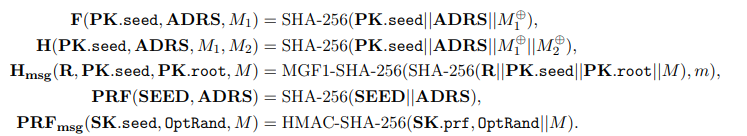

In [12]:
def F(pk_seed, adrs, m1):
    mask = generate_mask(m1, pk_seed, adrs, len(m1))
    mess = pk_seed + adrs_to_bytes(adrs) + mask
    return sha256(mess).digest()

In [13]:
def H(pk_seed, adrs, m1, m2):
    mask1 = generate_mask(m1, pk_seed, adrs, len(m1))
    mask2 = generate_mask(m2, pk_seed, adrs, len(m2))
    mess = pk_seed + adrs_to_bytes(adrs) + mask1 + mask2
    return sha256(mess).digest()

In [14]:
def H_msg(r, pk_seed, pk_root, m):
    mess = r + pk_seed + pk_root + m
    sha = sha256(mess).digest()
    return MGF1(sha, len(m))

In [15]:
def PRF(seed, adrs):
    mess = seed + adrs_to_bytes(adrs)
    return sha256(mess).digest()

In [16]:
def PRF_msg(sk_seed, sk_prf, opt_rand, m):
    hmac_value = hmac.new(sk_prf, opt_rand + m , sha256)
    return hmac_value.digest()

### Hash Function Address Scheme

An address ADRS is a 32-byte value that follows a defined structure. We use 5 different address structures later in the algorithms.

1) WOTS+ hash address:

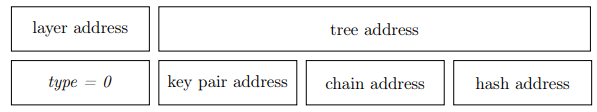

2) WOTS+ public key compression address:

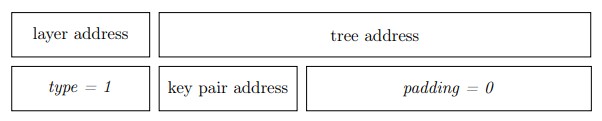

3) Hash tree address:

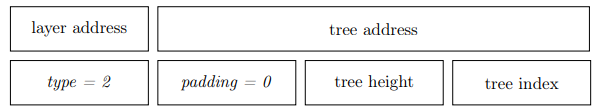

4) FORS tree address:

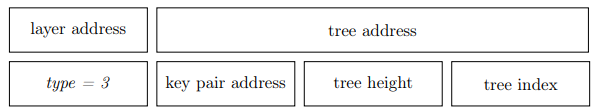

5) FORS tree roots compression address:

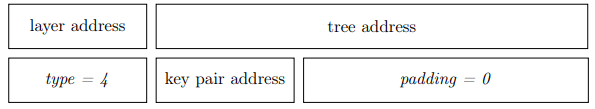

## WOTS+

The **WOTS+ _(Winternitz One-Time Signature Plus)_** algorithm is a component of the SPHINCS+ digital signature scheme. It is used to generate one-time digital signatures for individual message blocks. WOTS+ each private key **MUST NOT** be used to sign more than a single message.

WOTS+ is an improvement over WOTS designed to prevent certain attacks. The idea is that instead of just using the plain hash function H each time in the hash chain, a different chaining function is used every time derived from a "family" of keyed hash functions - **a tweakable hash function**. 

Parameters:
* _n_ - the security parameter - it is the message length as well as the length of a private key, public key, or signature element in bytes
* _w_ - the Winternitz parameter; it is an element of the set {4, 16, 256}

These parameters are used to compute values _len_, _len1_ and _len2_:

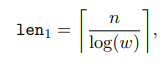

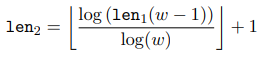



In [17]:
n = 32
w = 16
h = 64
len1 = ceil(n/log2(w))
len2 = floor(log2(len1*(w-1))/log2(w)) + 1
length = len1 + len2
print(len1, len2, length)

8 2 10


### Chaining Function

the chaining function is used to chain together the output of a hash function over multiple iterations. 

Input:
* _X_ - input string
* _i_ - start index
* _s_ - a number of steps
* _pk_seed_ - public seed
* _adrs_ - 32-byte WOTS+ hash address

Output: value of F iterated s times on X

In [18]:
# def chain(X, i, s, pk_seed, adrs):
#     for hashaddr in range(i, s):
#         adrs_copy = deepcopy(adrs)
#         adrs_copy[3] = num_to_bytes(hashaddr)
#         X = F(pk_seed, adrs_copy, X)
#     return X, adrs

def chain(h, n, pk_seed, adrs):
    for i in range(n):
        h = F(pk_seed, adrs, h)
    return h, adrs

### Private key generation

The WOTS+ private key, denoted by _sk (s for secret)_, is a length _len_ array of n-byte strings. This private key MUST NOT be used to sign more than one message.

Input:
* _sk_seed_ - secret seed
* _adrs_ - WOTS+ hash address

Output: WOTS+ private key _sk_

In [19]:
def wots_SKgen(sk_seed, adrs, length):
    sk = []
    for i in range(length):
        adrs[2] = num_to_bytes(i) # chain address
        sk.append(PRF(sk_seed, adrs))
    return sk, adrs

### Public key generation

Public key is generated from the _pk_seed_ and a chained _w_-times secret key.

Input:
* _sk_seed_ - secret seed
* _adrs_ - WOTS+ hash address
* _public_seed_ - public seed

Output: WOTS+ public key _pk_

In [20]:
def wots_PKgen(sk_seed, pk_seed, adrs):
    wotspkadrs = deepcopy(adrs)
    tmp = []
    pk = []
    for i in range(length):
        adrs[2] = num_to_bytes(i) # chain address
        sk = PRF(sk_seed, adrs)
        chain_res, adrs = chain(sk, w-1, pk_seed, adrs)
        tmp.append(chain_res)
    wotspkadrs[0] = num_to_bytes(1) # set type to WOTS_PK
    wotspkadrs[1] = deepcopy(adrs[1]) # key pair
    pk = sha256(pk_seed + adrs_to_bytes(wotspkadrs) + adrs_to_bytes(tmp)).digest()
    return pk, adrs

In [21]:
# generate keys
SK_SEED = randbytes(n)
PK_SEED = randbytes(n)
ADRS = [b'\0' * 8] + [randbytes(8) for _ in range(3)]
M = b"Ala uvhjbkma kotka a kotek ma tez Ale!"

wots_sk, adrs = wots_SKgen(SK_SEED, ADRS, length)
wots_pk, adrs = wots_PKgen(SK_SEED, PK_SEED, adrs)

### Signature Generation

A WOTS+ signature is a length _len_ array of n-byte strings. The WOTS+ signature is generated by mapping a message M to _len_ integers between 0 and w − 1 using the _base_w_ method. Next, a checksum over M is computed and appended to the transformed message as _len2_ base-w numbers, also using the _base_w_ function. Each of the _base-w_ integers is used to select a node
from a different hash chain. The signature is formed by concatenating the selected nodes.

Input:
* _M_ - message
* _sk_seed_ - secret seed
* _pk_seed_ - public seed
* _adrs_ - WOTS+ hash address

Output: WOTS+ signature _sig_

In [22]:
def wots_sign(m, sk_seed, pk_seed, adrs, len1):
    csum = 0
    adrs2 = deepcopy(adrs)
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
    
    # convert csum to base w
    csum = rot_left(csum, (8 - ((len2 * int(log2(w)) % 8))))
    msg = msg + base_w(num_to_bytes(csum), w, len2)
    sig = []
    # Compute F^m(sk)
    for i in range(length):
        adrs[2] = num_to_bytes(i) # chain
        sk = PRF(sk_seed, adrs)
#         tmp, adrs = chain(sk, 0, msg[i], pk_seed, adrs)
        tmp, adrs = chain(sk, msg[i], pk_seed, adrs)
        sig.append(tmp)
    return sig, adrs

In [23]:
# generate a signature
wots_sig, adrs = wots_sign(M, SK_SEED, PK_SEED, adrs, len1)
wots_sig

[b'\xd3K\x9f9\xf2\xbd\x15\xa6\xaf^\xf3\x14m\xf9[\xec\x11\xed~\\K\xe9G\xd4\x05\xa3j\xd2\xdd\x87\xa6\xd5',
 b'\xec\xe0\x89U\xab\xce\n\xaa6\x00\xa0H\x9cC;^\xc7\x8bxRa\x85\xe4\xd4\x81\xe4\xaaO\x1fr\xf9W',
 b'&[Ng*!\xa65F\xcf%?U\x9a(\xc0\xbb{\x18\xd6;\xb9Uga\x17\x0ef\x142\x9bN',
 b'7\xb5\xa5\x16\xa6\x81\x8cn\x1cR\x92P\xc9\xdc\x84\x0bpQl\xc1\xd9 j\xcc,s\x91G\x92\xda\xeb\xd4',
 b'\xfd\xb2H\xc7E>\xf2\x00\xbb2\xe8\xa7/A\x11\x0e\x82\x0c\x1c_\x06\xf4\x88?\xecW\xd6\xc5\xc2O\xf9\xa7',
 b"\x0f-jR\xf6\x87\x7f\x05\xf9\xdd\x85O\xd26\xcc\xd7l\xe2ho\xe6G'\xb2\xe5\xa9\xfd\x98g <\xfc",
 b"X\xa1\x020^\xdc\x19X\xa9p\xc5'\x06\xd3@\x7f\xe4\x89\x98v\xafKx\x9cm\x92\\\x80\x05\xa5\xefm",
 b'\x9dn\xa9\x90J\x9dC\x12 .\xd2\x0c\xe9\x05\x07\x10\xd4n\x8bIqPHE\xc5\xe4\\\xe6\xe9\xfa\x10\xa6',
 b':\x01\rT4\xd0\xedu\xc9;L\x04|e\xa7\x8e\x93\xeb\x1f\xf7\xf5\x84\x8c\xd0\xae\xf4Y\r\xd4\xb1\xfda',
 b'3B2\xd8\xb6I\xb3\x01\xcd\x81\xe98\x0b\xf0L\x04\xdd\xaa&\xe4J\x98\xea\xb0\xca\xe3A.\xde!+\x1f']

### Compute Public Key from Signature

In order to verify a WOTS+ signature _sig_ on a message M, the verifier computes a WOTS+ public key value from the signature.

In [24]:
def wots_pk_from_sig(sig, m, pk_seed, adrs):
    csum = 0
    adrs2 = deepcopy(adrs)
    wotspkadrs = deepcopy(adrs)
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
        
    # convert csum to base w
    csum = rot_left(csum, ( 8 - ( ( len2 * int(log2(w)) ) % 8 )))
    msg += base_w(num_to_bytes(csum), w, len2)
    tmp = []
    pk_sig = []
    for i in range(length):
        adrs2[2] = num_to_bytes(i) # chain
        t, adrs2 = chain(sig[i], w-1-msg[i], pk_seed, adrs2)
        tmp.append(t)
    wotspkadrs[0] = num_to_bytes(1)
    wotspkadrs[1] = deepcopy(adrs2[1])
    pk_sig = sha256(pk_seed + adrs_to_bytes(wotspkadrs) + adrs_to_bytes(tmp)).digest()
    return pk_sig, adrs

In [25]:
# compare public keys
sig_pk, adrs = wots_pk_from_sig(wots_sig, M, PK_SEED, adrs)

In [26]:
for i in range(len(wots_pk)):
    if wots_pk[i] != sig_pk[i]:
        print(False)
        break
else:
    print(True)

True


## XMSS

XMSS is a method for signing a potentially large but fixed number of messages. It is based on the Merkle signature scheme. We use it to build the **hypertree**. The leaves are the WOTS+ public keys. The XMSS public key is the root node of the tree.

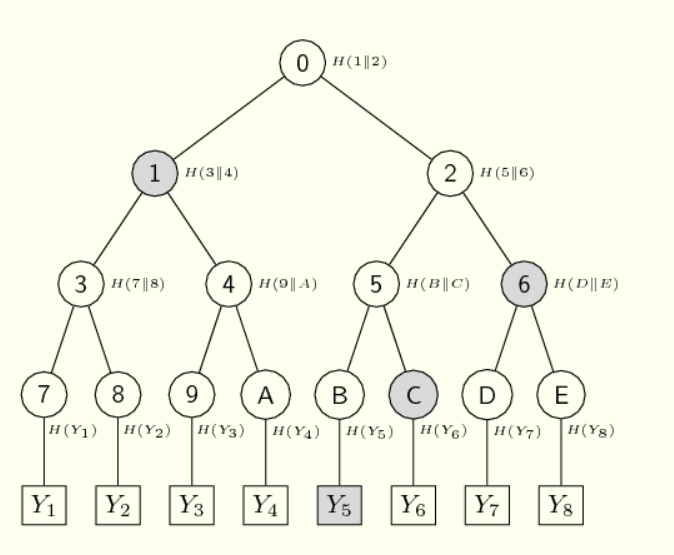

Parameters:
* _h'_ - the height (number of levels - 1) of the tree
* _n_ - the length in bytes of messages as well as of each node
* _w_ - the Winternitz parameter as defined for WOTS+

In [27]:
h_prim = 3
n = 32
w = 16

In [28]:
class TreeNode:
    def __init__(self, value, index, height):
        self.value = value
        self.index = index
        self.height = height
        self.left = None
        self.right = None
        self.parent = None
    
    def __repr__(self):
        return f"{self.value}, index: {self.index}, height: {self.height}"

### Treehash algorithm

Algoritm that computes the internal n-byte nodes of a Merkle tree.

Input:
* _sk_seed_ - secret seed
* _s_ - start index
* _z_ - target node height
* _pk_seed_ - public seed
* _adrs_ - WOTS+ pk address

Output: n-byte root node
(The height of a node is stored alingside a node's value)

In [29]:
def treehash(sk_seed, s, z, pk_seed, adrs):
    if s % rot_left(1, z) != 0:
        return None
    
    stack = []
    hash_adrs = deepcopy(adrs)
    hash_tree_adrs = deepcopy(adrs)
    
    # add first element of height 0 
    tree_node = TreeNode(b'', None, 0) # height = 0
    stack.append(tree_node)
    current = TreeNode(b'', None, None)
        
    for i in range(rot_left(1, z)):
        hash_adrs[0] = num_to_bytes(0) # wots hash
        hash_adrs[1] = num_to_bytes(s+i) # key pair
        leaf, hash_adrs = wots_PKgen(sk_seed, pk_seed, hash_adrs)
        hash_tree_adrs[0] = num_to_bytes(2) # tree type
        hash_tree_adrs[2] = num_to_bytes(1) # tree height
        tree_height = 1
        hash_tree_adrs[3] = num_to_bytes(s+i) # tree index
        tree_idx = s + i
        while stack[-1].height == int.from_bytes(hash_tree_adrs[2], 'big'):
            tree_idx = (int.from_bytes(hash_tree_adrs[3], 'big') - 1) // 2
            hash_tree_adrs[3] =  num_to_bytes(tree_idx)
            current = stack.pop()
            leaf = H(pk_seed, adrs, current.value, leaf)
            tree_height = int.from_bytes(hash_tree_adrs[2], 'big') + 1
            hash_tree_adrs[2] = num_to_bytes(tree_height)
        current.height = tree_height
        current.index = tree_idx
        current.value = leaf
        stack.append(current)
        current = TreeNode(b'', None, None)
    current = stack.pop()
    return current

### XMSS Public Key Generation

The XMSS public key PK is the root of the binary hash tree which is
computed using treehash.

Input: 
* _sk_seed_ - secret seed
* _pk_seed_ - public seed
* _adrs_ - tree address

Output: XMSS public key _pk_

In [30]:
def xmss_PKgen(sk_seed, pk_seed, adrs):
    pk = treehash(sk_seed, 0, h_prim, pk_seed, adrs)
    return pk

In [31]:
adrs = [num_to_bytes(2), b'\0' * 8] + [randbytes(8) for _ in range(2)]
xmss_pk = xmss_PKgen(SK_SEED, PK_SEED, ADRS)
xmss_pk

b'\xf2\x8a,\xdfz\x02\x84\xa2\xba\xab>\x00\xc4\xcfQ\x1a\x83[\xd4\x07\xed\xd77\xa0\xaa\x85\x86g\x01\xfc\xb9/', index: 0, height: 4

### XMSS Signature

An XMSS signature is a _((len + h') ∗ n))_-byte string consisting of:
* a WOTS+ signature sig taking _len * n_ bytes,
* the authentication path AUTH for the leaf associated with the used WOTS+ key pair taking _h' * n_ bytes. For the ith WOTS+ key pair, counting from zero, the jth authentication path node is:

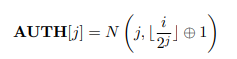

where:
_N(x, y)_ denotes the yth node on level x with y = 0 being the leftmost node on a level. The leaves are on level 0, the root is on level h'.


The XMSS signature:
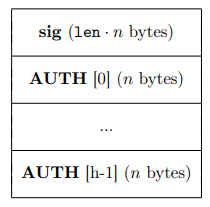

Input:
* _M_ - n-byte message M
* _sk_seed_ - secret seed
* _idx_ - index
* _pk_seed_ - public seed
* _adrs_ - tree type address

Output: XMSS signature _sig_xmss_

In [32]:
def xmss_sign(m, sk_seed, idx, pk_seed, adrs):
    # build authentication path
    auth = []
    for j in range(h_prim):
        k = floor(idx / pow(2,j)) ^ 1
        root = treehash(sk_seed, k * pow(2,j), j, pk_seed, adrs)
        auth.append(root)
    hash_adrs = deepcopy(adrs)
    hash_adrs[0] = num_to_bytes(0)
    hash_adrs[1] = num_to_bytes(idx)
    sig, adrs = wots_sign(m, sk_seed, pk_seed, hash_adrs, len1)
    return sig, auth

In [33]:
sig_xmss = xmss_sign(M, SK_SEED, 0, PK_SEED, adrs)
sig_xmss

([b'I^\x01\xaa"\x19+\xe0\n\xf6\xe5>3\x10S\x08\xbe\x87\x05\xf4\xcf\xc4\x85\xc4\x9dn\xaa\x98\xbdl\x03\x9a',
  b'PQ\xe7vR]\xd8Us\xc8\\V"\xe9\xed\xc9\x10\xda\xcf9\xfcar\xfc\xf3)\x16\xc9T\xe50-',
  b'\xc1MDsg\x87`\xa4\x8c \xf4\x98\x8e\xa9\xbbvB\xebh\xc8\xc6\xb1\xe7\xe0\xa6mO\x8d\xc4Lf0',
  b"\x93\x16\xd3'\xe0D\xc4\xa5O\xaf\xd1|1}n\x97\xf2\x1bU`\xa21s8\x15>\x98l2\xb6e\xd5",
  b'\xbc\xb44\x089\xa6.\xbfE\x15KY2_d\x87\xca9/\x8aM\xfd\x8b\x82\x1a\x8a:\xd3\n_\xe03',
  b'\x08f\xf5\xde\x8b\x8fQN,\xadFh:\xed\xf1p\x90\xab\xd0\x05\xff\xe6\xc3\x81{\x87\xb2\xebuJ\xca ',
  b"\xdf\x02\x18\x05\xbb\xb3(3J]\xbd\xae\xd1\x9f\xc6\x81\xa4\x8f\xdf,\xe3~\x84\x1a\xf9r\\\x01\x9d\xa4\xfd'",
  b'\x8e%\xe4\xbe\xe3\xbf\xb8x\xaa`\xcb\xfd\x0f\xbd\x01\x14\xf6\x8c\xc5\x11\x82\xce\xe6)\xe4Y$\xdb\x7f;\xcd\x82',
  b'I,\xd8\xc6\xff\xe0\x92b\x9e\x81b1lZ\xe4\xfb\xfbZ\x84ID0\xe3Y\r\xcf[\x12\xcd\xd3\x93S',
  b'\xd3\xe4K[\x95r\x91F\x8e\x07\xa5\xbf\x0e\xefV\xed~\xfe\xdb~,9>\xaf\x9a\xd0\x0c\xd0iFB\xa6'],
 [b'\xb5\xe7\x1c\xb89X\x19&\xcf

### XMSS Compute Public Key from Signature

We don't use the XMSS verification algorithm, but we calculate the public key value from XMSS signature because that's what we'll need in future computations.

Input:
* _idx_ - index
* _sig_xmss_ - XMSS signature
* _M_ - n-byte message
* _pk_seed_ - public seed
* _adrs_ - WOTS+ hash address

 Output: _pk_ - n-byte root value node[0]

In [34]:
def xmss_pk_from_sig(idx, sig_xmss, m, pk_seed, adrs):
    # compute wots+ pk from wots+ sig
    hash_adrs = deepcopy(adrs)
    hash_tree_adrs = deepcopy(adrs)
    
    hash_adrs[0] = num_to_bytes(0)
    hash_adrs[1] = num_to_bytes(idx)
    sig, auth = sig_xmss
    leaf, adrs = wots_pk_from_sig(sig, m, pk_seed, hash_adrs)
    node = [leaf, None]
    
    # compute root from wots+ pk and auth
    hash_tree_adrs[0] = num_to_bytes(2)
    hash_tree_adrs[3] = num_to_bytes(idx)
    for k in range(h_prim):
        if floor(idx/pow(2,k)) % 2 == 0:
            hash_tree_adrs[3] = num_to_bytes(int.from_bytes(hash_tree_adrs[3], 'big') // 2)
            node[1] = H(pk_seed, hash_tree_adrs, auth[k].value, node[0])
        else:
            hash_tree_adrs[3] = num_to_bytes((int.from_bytes(hash_tree_adrs[3], 'big') - 1) // 2)
            node[1] = H(pk_seed, hash_tree_adrs, auth[k].value, node[0])
        node[0] = node[1]
    return node[0]

In [35]:
xmss_sig_pk = xmss_pk_from_sig(0, sig_xmss, M, PK_SEED, adrs)
xmss_sig_pk

b'\xebm:\xd6\xf6YfqC|\x87\xc4)7\xa9\x0c\xaa\xb687h\x1e+\xa6?\xf6\xa9qo\x88\x17Y'

In [36]:
xmss_pk

b'\xf2\x8a,\xdfz\x02\x84\xa2\xba\xab>\x00\xc4\xcfQ\x1a\x83[\xd4\x07\xed\xd77\xa0\xaa\x85\x86g\x01\xfc\xb9/', index: 0, height: 4

In [37]:
xmss_pk.value == xmss_sig_pk

False

## Hypertree

A **hypertree** is a tree of several layers of XMSS trees. The trees on top and
intermediate layers are used to sign the public keys. Trees on the lowest layer are used to sign the actual messages, which are FORS public keys in SPHINCS+. All XMSS trees in HT have equal height.

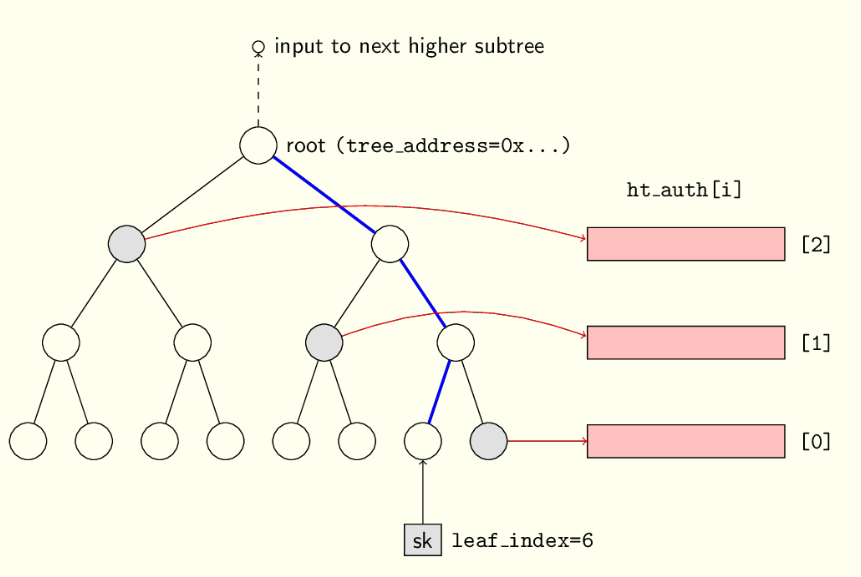

Parameters:
* _h_ - hypertree height
* _d_ - number of tree layers

In [38]:
h = 3
d = 1

### HT Key Generation

The HT public key is the public key (root node) of the single XMSS tree on the top layer.

Input:
* _sk_seed_ - private seed
* _pk_seed_ - public seed

Output: HT public key _pk_ht_

In [39]:
def ht_pk_gen(sk_seed, pk_seed):
    for i in range(4):
        adrs[i] = num_to_bytes(0, length=8)
    adrs[0] = num_to_bytes(d-1)
    root = xmss_PKgen(sk_seed, pk_seed, adrs)
    return root

In [40]:
ht_pk = ht_pk_gen(SK_SEED, PK_SEED)
ht_pk

b'\xd5\x9d}"M_\xab\x85+\x1f\xd5\x1dEj9\x05\xa4\xec\xc7\xc2\x9cRul\xdb\x10h\x8d~!Hr', index: 0, height: 4

### HT signature

A HT signature SIGHT is a byte string of length _(h + d ∗ len) ∗ n_. It consists of _d_ XMSS signatures (of _(h/d + len) ∗ n_ bytes each). 

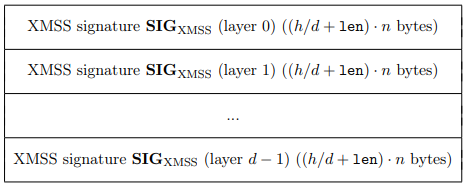


Signature algorithm uses _xmss_pk_ from_sig_ to compute the root node of an XMSS instance
after that instance was used for signing.

Input: 
* _M_ - message
* _sk_seed_ - secret seed
* _pk_seed_ - public seed
* _idx_tree_ - tree index
* _idx_leaf_ - leaf index

Output: HT signature _sig_ht_

In [41]:
def ht_sign(m, sk_seed, pk_seed, idx_tree, idx_leaf):
    # init
    hash_adrs = [None, None, None, None]
    for i in range(4):
        hash_adrs[i] = num_to_bytes(0, length=8)
    
    # sign
    hash_adrs[0] = num_to_bytes(0)
    tree_adrs = num_to_bytes(idx_tree, length=24)
    hash_adrs[1] = tree_adrs[:8]
    hash_adrs[2] = tree_adrs[8:16]
    hash_adrs[3] = tree_adrs[16:]
    sig_tmp = xmss_sign(m, sk_seed, idx_leaf, pk_seed, hash_adrs)
    sig_ht = [sig_tmp]
    # xmss_sig_pk = xmss_pk_from_sig(0, sig_xmss, M, PK_SEED, adrs)
    root = xmss_pk_from_sig(idx_leaf, sig_tmp, m, pk_seed, adrs)
    for j in range(1, d):
        idx_leaf = int(tree & (left_rot(1, h_prim) - 1)) # least significant bits of idx_tree
        idx_tree = right_rot(idx_tree, h_prim) # most significant bits of idx_tree
        hash_adrs[0] = num_to_int(j)
        adrs[1] = idx_tree[:8]
        adrs[2] = idx_tree[8:16]
        adrs[3] = idx_tree[16:]
        adrs[2] = num_to_bytes(h_prim) # tree address
        sig_tmp = xmss_sign(root, sk_seed, idx_leaf, pk_seed, adrs)
        sig_ht.append(sig_tmp)
        if j < d - 1: # //we switched to another tree and need a new public key
            root = xmss_pk_from_sig(idx_leaf, sig_tmp, root, pk_seed, adrs)
    return sig_ht, adrs
    

In [42]:
sig_ht, adrs = ht_sign(M, SK_SEED, PK_SEED, 0, 0)
sig_ht

[([b"L%\xcc-J\xae\x05Z\x84\r\x80\xf7\xa7>3\x0b\xa2?7\xd7\xd5'\xf8\xd6[\xea2\xa9\xed\xce\xd1`",
   b'\xe8k/T\xa1U\xf6\xd52\x96\xff\x17v\xeb\n\xef\x08\x0e\x81\xd9t_l\xfd\x00\xac\xe5\x91\xc2\x8d\x9bG',
   b'\x9dx\xc2\x1a?\xe3\xc0KU\xd1$\xd0\xe5\xd2wBw\xb7\xb4\xd3\x03\xbc\x9f\xd1\xa3\xc0\x18\x1d\xc3\x8f\xa9\x16',
   b'=\xaa\xb1\xa33\xe4\x92\xf7\x85E\xe9\xf9J\xe2\xa4^\x94@\xbf:i`\xb4\xd5R\xa7r\xf1T\xe7\x87b',
   b'\xd3L\xbf\x08j]\xeaW\xbf\x08\xba\x06\xc6b\xdf\xeb\xf6\xa9\xa6\xce\x8f\x04Aw\xa5\xc46T\xd3\xbd\xcc]',
   b'\xdd\x80\x8b\xc4"^\x80\xccv\xb2\xc5\x93\xc2ON\xbbp\x82\xae\xc3$?"\x8b\xb0+=_\xe9\xda\xabJ',
   b'\x18\x96\xf1\x8d?\xe0\x83\x83$;\xb7\xday\x86\x13\x9f\xed\x8aZ\xc1\xd4\x97\x18E\x86Nvv\xf0\x05\xd9\xc5',
   b"\xa6\x14\xa3\xa8\xa6Y\xc6\xf5\xbfg\xa6\rjbW\tq'\x1e\n\x17\x8f\x14^\xb3\r\xef\xe5PX\x83@",
   b'\xa3\xe8\x02\xfc\x10\xb5\x15\xd1Q\x99I\xf5\xf6/\x9b \xd7\xeco\xf8\r&\x85b\xe6\x14\xf16D\x8c\xb0\x96',
   b'\xe3\xfag\x99Riy&~\\@n\x0be3\xbfyE\xdaK\xf7q\x01\xcc\x9fM|Q\xe2+\x93P'],


### HT Signature Verification

HT signature verification are _d_ calls to _xmss_pk_from_sig_ and
one comparison with a given private key value.

Input:
* _M_ - message
* _sig_ht_ - signature
* _pk_seed_ - public seed
* _idx_tree_ - tree index
* _idx_leaf_ - index leaf
* _pk_ht_ - HT public key

In [43]:
def ht_verify(m, sig_ht, pk_seed, idx_tree, idx_leaf, pk_ht):
    # init
    hash_adrs = [None, None, None, None]
    for i in range(4):
        hash_adrs[i] = num_to_bytes(0, length=8)
    
    # verify
    sig_tmp = sig_ht[0] # first xmss_sig
    hash_adrs[0] = num_to_bytes(0)
    tree_adrs = num_to_bytes(idx_tree, length=24)
    hash_adrs[1] = tree_adrs[:8]
    hash_adrs[2] = tree_adrs[8:16]
    hash_adrs[3] = tree_adrs[16:]
    node = xmss_pk_from_sig(idx_leaf, sig_tmp, m, pk_seed, hash_adrs)
    for j in range(1, d):
        idx_leaf = int(tree & (left_rot(1, h_prim) - 1)) # least significant bits of idx_tree
        idx_tree = right_rot(idx_tree, h_prim) # most significant bits of idx_tree
        sig_tmp = sig_ht[j]
        hash_adrs[0] = num_to_bytes(j)
        hash_adrs[1] = idx_tree[:8]
        hash_adrs[2] = idx_tree[8:16]
        hash_adrs[3] = idx_tree[16:]
        node = xmss_pk_from_sig(idx_leaf, sig_tmp, node, pk_seed, hash_adrs)
    if node == pk_ht:
        return True
    return False

In [44]:
ht_verify(M, sig_ht, PK_SEED, 0, 2, ht_pk)

False

## FORS: Forest Of Random Subsets

The SPHINCS+ hypertree HT is not used to sign the actual messages but the public keys of FORS instances which in turn are used to sign the messages.

FORS is an improvement on HORS, designed by the SPHINCS+ team. FORS is similar to HORS except we have kt sets of private keys and k binary hash trees.

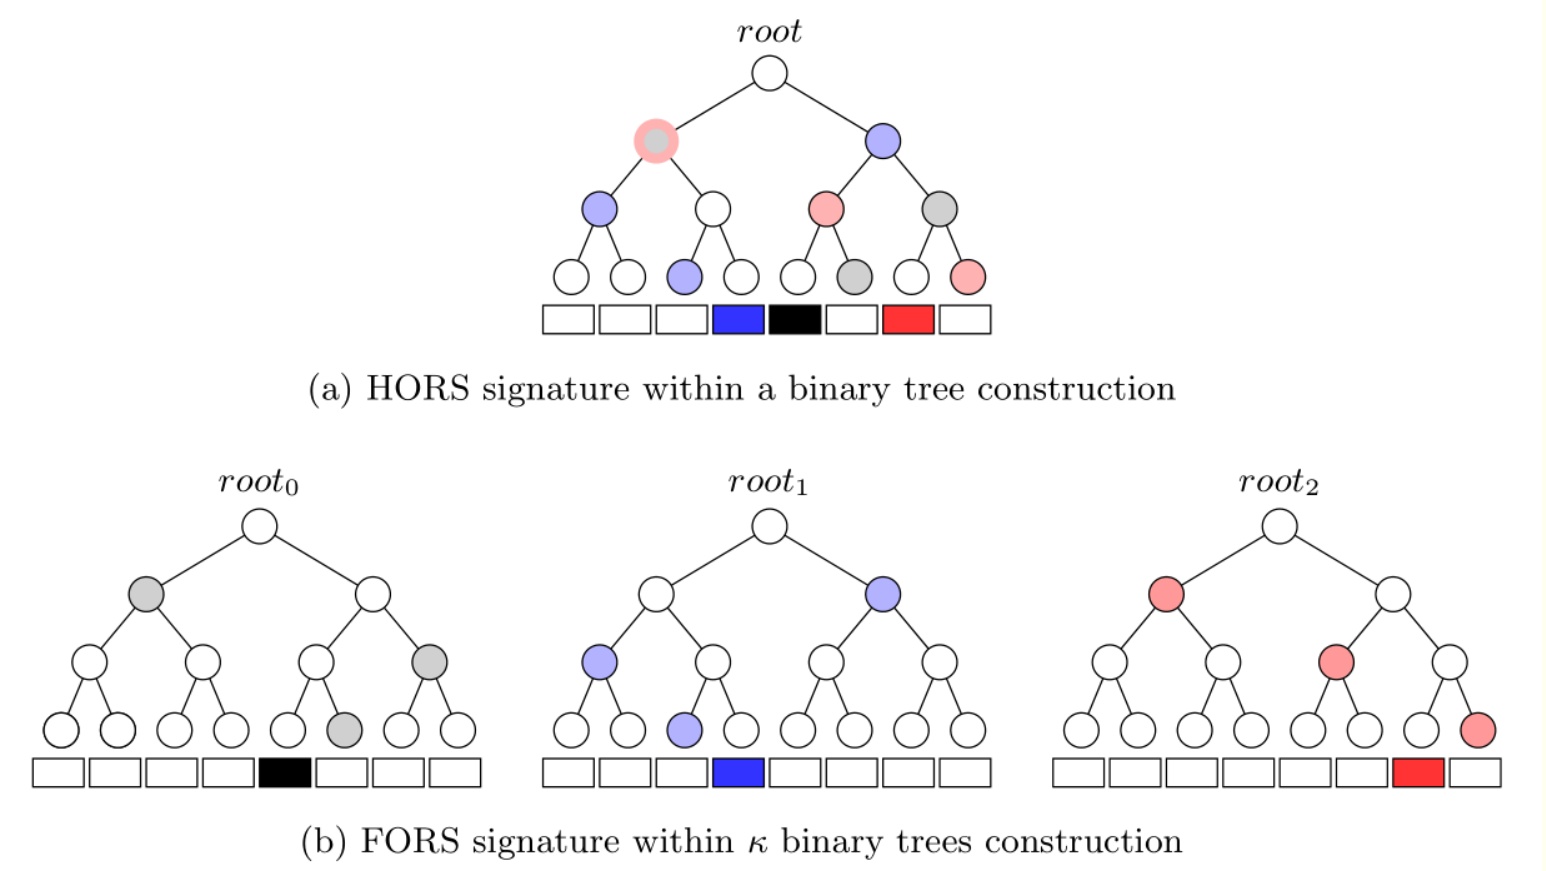

Unlike HORS, which selects all its signature values from the same set of t keys, FORS generates kt secret keys and dedicates t secret keys for each index out of the k indices.
FORS mitigates against weak message attacks because, even if two bitstring segments produce an integer of the same value, their index values form different secret paths.

Parameters:
* _n_ - the security parameter; it is the length of a private key, public key, or signature element in bytes.
* _k_ - the number of private key sets, trees and indices computed from the input string.
* _t_ - the number of elements per private key set, number of leaves per hash tree and upper bound on the index values. The parameter t MUST be a power of 2. If t = 2a, then the trees have height a and the input string is split into bit strings of length a.

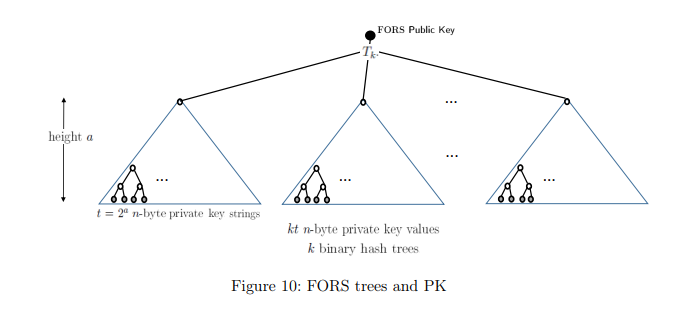

In [45]:
k = 1
a = h_prim
t = 2 * h_prim
print(k, a, t)

1 3 6


### FORS Private Key

It is used to generate the private key values using PRF with an address.

Input:
* _sk_seed_ - secret seed
* _adrs_ - FORS tree 

Output: FORS private key _sk_

In [46]:
def fors_sk_gen(sk_seed, adrs, idx):
    skadrs = deepcopy(adrs)
    skadrs[0] = num_to_bytes(3)
    skadrs[2] = num_to_bytes(0)
    skadrs[3] = num_to_bytes(idx)
    sk = PRF(sk_seed, adrs)
    return sk

### FORS Tree Hash

Function that computes the n-byte nodes of the FORS trees.

Input:
* _sk_seed_ - secret seed
* _s_ - start index
* _z_ - target node height
* _pk_seed_ - public seed
* _adrs_ - FORS tree address

Output: n-byte root node - top node on Stack

In [47]:
def fors_treehash(sk_seed, s, z, pk_seed, adrs):
    if s % rot_left(1, z) != 0:
        return None
    
    stack = []
    current = TreeNode(b'', None, 0)
    stack.append(current)
    for i in range(pow(2,z)):
        sk = fors_sk_gen(sk_seed, adrs, s+i)
        node = F(pk_seed, adrs, sk)
        adrs[2] = num_to_bytes(1)
        adrs[3] = num_to_bytes(s+i)
        while stack[-1].height == int.from_bytes(adrs[2], 'big'):
            tree_idx = (int.from_bytes(adrs[3], 'big') - 1) // 2
            adrs[3] = num_to_bytes(tree_idx)
            current = stack.pop()
            node = H(pk_seed, adrs, current.value, node)
        current.height = int.from_bytes(adrs[2], 'big') + 1
        current.value = node
        stack.append(current)
        current = TreeNode(b'', None, 0)
    current = stack.pop()
    return current

### FORS Public Key

The FORS public key is the value on top of out forest. It is NEVER generated alone. It is only generated together with a signature.

Input:
* _sk_seed_ - secret seed
* _pk_sed_ - public seed
* _adrs_ - FORS tree address

Output: FORS public key _pk_

In [48]:
def fors_pkgen(sk_seed, pk_seed, adrs):
    forspkadrs = deepcopy(adrs)
    root = []
    for i in range(k):
        r = fors_treehash(sk_seed, i*k, a, pk_seed, forspkadrs)
        root.append(r.value)
    forspkadrs[0] = num_to_bytes(4)
    pk = sha256(pk_seed + adrs_to_bytes(forspkadrs) + adrs_to_bytes(root)).digest()
    return pk

In [60]:
fors_pk = fors_pkgen(SK_SEED, PK_SEED, adrs)
fors_pk

b'\x12\x91\xb8\xfa+_\xa2\x1e\xb7\xd5\xa4\xe2\xcc\xc8.\xa9\xfbVUe\x16\xb1\x00\xa9\x9b\xf2\x81\xbe\x1b\xa4\xe7\xf3'

### FORS Signature Generation

A FORS signature is a length _k(log t + 1)_ array of n-byte strings. It contains _k_ private key values, n-bytes each, and their associated authentication paths, _log t_ n-byte values each.

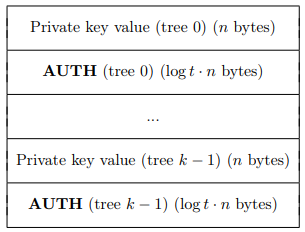

Input:
* _M_ - message
* _sk_seed_ secret seed
* _adrs_ - FORS tree address
* _pk_seed_ - public seed

Output: FORS signature _sig_fors_

In [50]:
def message_to_indices(msg):
    offset = 0
    indices = [0] * k
    
    for i in range(k):
        indices[i] = 0  # possible omission
        
        for j in range(a):
            indices[i] ^= ((msg[offset >> 3] >> (offset & 0x7)) & 0x1) << j
            offset += 1
    
    return indices

In [51]:
def fors_sign(m, sk_seed, pk_seed, adrs, a):
    # compute signature elements
    sig_fors = []
    indices = message_to_indices(m)
    for i in range(k):
        # get next index
        idx = i * t
        
        # pick private key element
        adrs[2] = num_to_bytes(0)
        idx_offset = i * t
        adrs[3] = num_to_bytes(indices[i] + idx_offset)
        sig_f = PRF(sk_seed, adrs)
        
        # compute auth path
        auth = []
        for j in range(a):
            s = floor(idx/(pow(2, j))) ^ 1
            a = fors_treehash(sk_seed, i*k + s * pow(2,j), j, pk_seed, adrs)
            auth.append(a)
        sig_fors.append((sig_f, auth))
    return sig_fors

In [52]:
sig_fors = fors_sign(M, SK_SEED, PK_SEED, adrs, a)
sig_fors

[(b'UM\x80\xce\x9d*\xb6\x80\x9a\xe4\xbe\x18\xc5\xc1\xebj5\x98\xe2I\x82\x02\x8f\xafs\x03\xaf!f\x93\x91\x0e',
  [b'\xaf\xf7n\xc7\x99\xc2\xa3\x9dsH\x1d\xfbb\x952\t\xfe\x05\xff0J"\xa1\x00\xe2qhkV\xe9\xd2\xce', index: None, height: 2,
   b'\xf6\xce\x86\xeb\x97\x9d\xd02\xc9\tk\xbe0\xd8\xe67\xf4a\xb2\xb8\x19\x1aR\xd5\xff\xf5\xe2\xd5\xc6\x89P\xd2', index: None, height: 2,
   b"\xd4l\x8b\t\x85\xa9\x07uw`'G\x0c[\x91\x06\xf6\xf03<\x16/\x11\xbd\xb5\xfd\xda\r\x1a\xc2\xe7\xcf", index: None, height: 2])]

### FORS Compute Public Key from Signature

A FORS signature is used to compute a candidate FORS public key. This public key is used in further computations (message for the signature of the XMSS tree above) and implicitly verified by the outcome of that computation.

Input:
* _sig_fors_ - FORS signature
* _M_ - message
* _pk_seed_ - public seed
* _adrs_ - FORS tree address

Output: FORS public key

In [53]:
def compute_fors_root(leaf, tree_height, leaf_idx, idx_offset, auth_path, fors_tree_adrs):
    n = len(leaf)
    right = bytearray(n)
    left = bytearray(n)

    for i in range(tree_height):
        # Compute auth path/node combination
        # If the current element is a right child node, the leaf index has to be odd
        if (leaf_idx & 1) != 0:
            # Leaf index is odd -> authPath || leaf
            left[:] = auth_path[n * i: n * (i + 1)]
            right[:] = leaf
        else:
            # Leaf index is even -> leaf || authPath
            right[:] = auth_path[n * i: n * (i + 1)]
            left[:] = leaf

        # Shift to get next index/offset
        leaf_idx >>= 1
        idx_offset >>= 1

        # Set address for new node
        fors_tree_adrs.set_tree_height(i + 1)
        fors_tree_adrs.set_tree_index(leaf_idx + idx_offset)
        wots_hash.set_adrs(fors_tree_adrs)

        # Compute new node
        leaf = wots_hash.H(left, right)

    return leaf

In [54]:
def fors_pk_from_sig(sig_fors, m, pk_seed, adrs):
    # compute roots
    root = []
    indices = message_to_indices(m)
    for i in range(k):
        # get next index
        idx_offset = i * t
        
        # compute leaf
        adrs[3] = num_to_bytes(indices[i] + idx_offset)
        adrs[2] = num_to_bytes(0)
        node = [F(pk_seed, adrs, sig_fors[i][0]), None]
        
        # compute root from leaf and AUTH
        auth = sig_fors[i][1]
        idx = indices[i]
        adrs[3] = num_to_bytes(idx)
        for j in range(a):
            adrs[2] = num_to_bytes(j+1)
            if floor(idx/pow(2,j)) % 2 == 0:
                adrs[3] = num_to_bytes(int.from_bytes(adrs[3], 'big') // 2)
                node[1] = H(pk_seed, adrs, node[0], auth[j].value)
            else:
                adrs[3] = num_to_bytes((int.from_bytes(adrs[3], 'big') - 1) // 2)
                node[1] = H(pk_seed, adrs, auth[j].value, node[0])
            node[0] = node[1]
        root.append(node[0])
    forspkadrs = deepcopy(adrs)
    forspkadrs[0] = num_to_bytes(4)
    pk = sha256(pk_seed + adrs_to_bytes(forspkadrs) + adrs_to_bytes(root)).digest() # to mialo byc Tk czyli FORS public key?
    return pk

In [55]:
fors_pk_sig = fors_pk_from_sig(sig_fors, M, PK_SEED, adrs)
fors_pk_sig

b'Z|\xfb\xf6\xeaqd\x91\xc4\xeb\xb3\x04\x19\xcbW\x88H\xbb\xeb\\l\xe4\x14sM\xcef#\x0e\xf8\x8f\xae'

# SPHINCS+

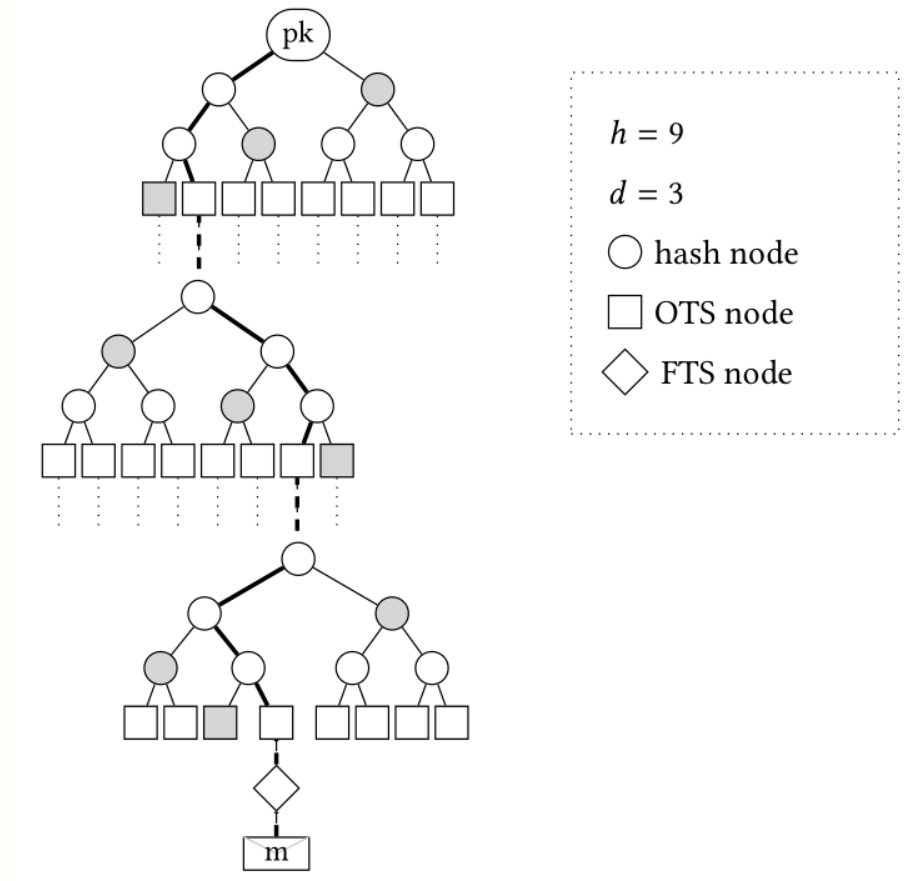

1. **We create the FORS trees.** The FORS public key value is not explicitly included in the signature, but is used as an input to the hypertree signature. Actually to the bottom layer of the hypertree using the WOTS+ algorithm. 
2. In the loop we compute the HT signatures from the bottom through the upper levels of the trees. The input is either the root of the lower HT tree root[i-1] or the FORS public key for the bottom HT tree at layer 0. 

Parameters:
* n - the security parameter in bytes.
* w - the Winternitz parameter
* h - the height of the hypertree
* d - the number of layers in the hypertree
* k - the number of trees in FORS
* t - the number of leaves of a FORS tree

### SPHINCS+ Key Generation

SPHINCS+ **public key** consists of:
* _pk_root_ - HT public key (the root of the hypertree on the top layer)
* _pk_seed_ - public seed

SPHINCS+ **private key** consists of:
* _sk_seed_ - secret seed which is used to generate all the WOTS+ and FORS private key elements.
* _sk_prf_ - PRF - which is used to deterministically generate a randomization value for the randomized message hash.
* _pk_root_ - HT public key (the root of the hypertree on the top layer)
* _pk_seed_ - public seed

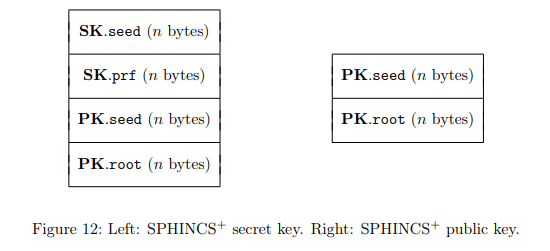

In [56]:
def spx_keygen():
    sk_seed = randbytes(n)
    sk_prf = randbytes(n)
    pk_seed = randbytes(n)
    pk_root = ht_pk_gen(sk_seed, pk_seed)
    return sk_seed, sk_prf, pk_seed, pk_root

In [57]:
sk_seed, sk_prf, pk_seed, pk_root = spx_keygen()

### SPHINCS+ Signature

1) Generate a random value _R_ 
   
In original algorithm when computing R, the PRF takes a n-byte string opt which is initialized with zero but can be overwritten with randomness if the global variable RANDOMIZE is set. This option is given as otherwise SPHINCS+ signatures would be always deterministic. In this implementation we omit this step because it's not that essencial.

 
2) Compute a m byte message digest 

Message digest is split into a _floor((k log t + 7)/8)_-byte partial message digest _tmp_md_, a _floor((h − h/d + 7)/8)_-byte tree, index _tmp_idx_tree_, and a _floor((h/d + 7)/8)_-byte leaf index _tmp_idx_leaf_.

3) Compute the actual values of _md_, _tmp_idx_tree_ and _idx_leaf_ by extracting the necessary number of bits.

4) Sign the partial message digest _md_ using _idx_leaf_th_ FORS key pair of the _idx_tree_th_ XMSS tree on the lowest HT layer

5) Sign the public key of the FORS key pair using HT

Input:
* _M_ - message
* _sk = (sk_seed, sk_prf, pk_seed, pk_root)_ - private key

Output: SPHINCS+ signature _sig_

In [58]:
def spx_sign(m, sk_seed, sk_prf, pk_seed, pk_root, a):
    # init
    adrs = [None, None, None, None]
    for i in range(4):
        adrs[i] = num_to_bytes(0, length=8)
    
    # generate randomizer
    opt = num_to_bytes(0, length=32)
    r = PRF_msg(sk_seed, sk_prf, opt, m)
    sig = [r]
    
    # compute message digest and index
    digest = H_msg(r, pk_seed, pk_root.value, m)
    tmp_md = digest[:floor((k*a + 7)/8)] # first floor((ka +7)/ 8) bytes of digest;
    tmp_idx_tree = digest[floor((k*a + 7)/8) : floor((k*a + 7)/8) + floor((h - h/d +7)/ 8)] # next floor((h - h/d +7)/ 8) bytes of digest;
    tmp_idx_leaf = digest[floor((k*a + 7)/8) + floor((h - h/d +7)/ 8):] # next floor((h/d +7)/ 8) bytes of digest;
    
    md = tmp_md[:k*a] # first ka bits of tmp_md;
    idx_tree = tmp_idx_tree[:(h_prim-h_prim//d)] # first h - h/d bits of tmp_idx_tree;
    idx_leaf = tmp_idx_leaf[:h_prim//d] # first h/d bits of tmp_idx_leaf;
    
    # FORS sign
    adrs[0] = num_to_bytes(3)
    adrs[1] = idx_tree[:8]
    adrs[2] = idx_tree[8:16]
    adrs[3] = idx_tree[16:]
    adrs[1] = idx_leaf
    
    sig_fors = fors_sign(md, sk_seed, pk_seed, adrs, a)
    s = b''
    for signature, auth_path in sig_fors:
        s += signature
    sig.append(s)
    
    # get FORS public key
    pk_fors = fors_pk_from_sig(sig_fors, m, pk_seed, adrs)
    
    # sign FORS public key with HT
    adrs[0] = num_to_bytes(2)
    sig_tmp = b''
    sig_ht, adrs = ht_sign(pk_fors, sk_seed, pk_seed, int.from_bytes(idx_tree, 'big'), int.from_bytes(idx_leaf, 'big'))
    for s in sig_ht:
        sig_tmp += adrs_to_bytes(s[0])
    sig.append(sig_tmp)
    return sig

In [59]:
spx_sig = spx_sign(M, sk_seed, sk_prf, pk_seed, pk_root, a)
spx_sig

[b'\xdb\xa6ON\xe9G\xc9\xd4 \x1b\x18\xe3\x9a\x9f\xf5\xc9!C\n#\\\x9av\xde?+\xaf\xc4\x08\xc8\x01j',
 b'v\xb2\xe1\x14\xd6\x8c\xdb\xd0\xde>@\xe1+\xf6\x16)\x18R\xd4N[k\x99y\xf2\x9d\xbf%\xd8\xc3\x82\xa0',
 b'^H\x07\xd8v\x9fL\x97:\x85%\xe8r\xa7d4\xc4\xff\x97;e\xc2M qy\xecu\x97\x99\xae\x88\r}\x88V\x0e\x17e\xe5\xb9\x1e\x82\xd34\xcfH\x1d\x11\xaf\x97.\xfa9\x19\xa0\x07\xef\xee^\xb9\ng^<\x80#\x9cu\xc3\xae\xbc\n\x96\xe2\xa2\xd7\x178/\xd3\xcfp\x9e\xd1A\xe7\x02\xa8\x88\x15(\xa5\x11\x18\x06b\xa2}[\x08CB\x1e\x99^\x03\x10\xf1\x88\x03\xe9\x89\x9e\x08\xcdS\xbd\xd6r\xa0\xf6\xc5\xe9\x04\x9c\x9f^/\xd21\xef\xbc0\xc5\x97\xa9|\x0ci\xf5s\x16\xbc-\xb6\xe9\xd3\x97\xd6\xb8\x1e\xbfPb_n\xcfL#\xbf!\xe5J\xd4*\xfb\xac_\xf9\x92\x9b\xcee\\\xc6\t\xaeo(\xd2\xfd<\xb2\x7f\xc2\x07\x90\'\x00d\xa8\xc9D\xe6)\xfd\x12\xe3\xbfO9\xe4#"\x86\x1e{\xf9\xf2tlF-/\xaf\xf0\xb8\x86d\xfb\xb8\x02q\x0f$\xb7\x05\x07\xf8Mh\xe7\x0e\xc8\xd3\xce\x05\xcb\x05X\x00^\xd0D\x01*&f)\xe0r:W\xff\xc5ki\x99Zg\x95\xe8\xb9\xe6q\x89\x10G\xa9\xf3\xd9\x83\xe3\xa3\x8c\